# Binomial Mixture Model with Expectation-Maximization (EM) Algorithm


## Generating Data

We first generate some data points which are randomly drawn from a Binomial Mixture Model with two Binomial Distributions. Given $N_i$, the probability of $n_i$ is

$P(n_i | N_i, \Theta) = \sum_{k=1}^{2}\pi_k \mathrm{Bino}(n_i|N_i, \theta_k)$, 

where the Binomial Distribution is

$\mathrm{Bino}(n_i|N_i, \theta) = {N_i!\over n_i!(N_i-n_i)!} \theta^{n_i} (1-\theta)^{N_i-n_i}$,

and the sum of $\pi$'s is unity, i.e.

$\sum_{k=1}^{2} \pi_k = 1$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binom

# size of dataset, S pairs of (ni, Ni)
S= int(1e3)

# the list of (Ni| i =1, 2, ..., S), uniformly drawn between 3000 and 6000
N_ls = np.random.randint(low=10, high=20, size=S)

# the theta's the two Binomial Distributions
theta_1 = 0.5
theta_2 = 0.3

# the probabilities, pi's, of the two Binomial Distributions
pi_1 = 0.7
pi_2 = 1.0 - pi_1
theta_ls = np.random.choice([theta_1,theta_2], size=S, p=[pi_1,pi_2])

# generate the list of (ni|i=1,2,...,S)
n_ls = []
for i in range(S):
    N = N_ls[i]
    theta = theta_ls[i]
    Binom = binom(N,theta)
    n = Binom.rvs(size = 1)[0]
    n_ls.append(n)
    
n_ls = np.array(n_ls)

Make some figures to get some visual impression of the dataset.

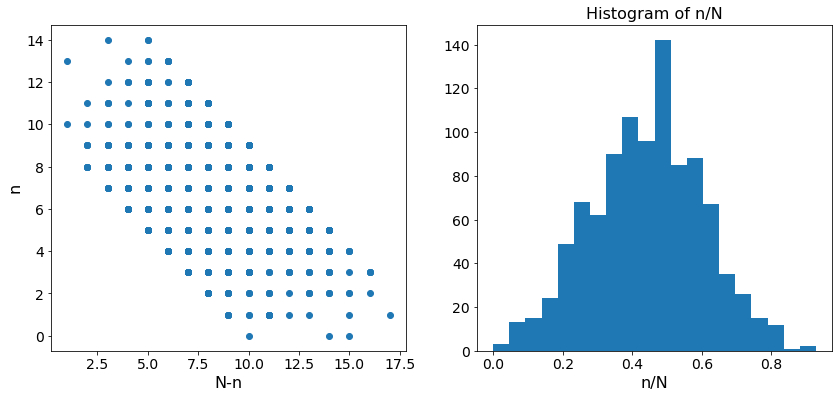

In [58]:
fig, axes = plt.subplots(1,2,figsize=(14,6))
axes[0].scatter(N_ls-n_ls, n_ls)
axes[0].set_xlabel("N-n",size=16)
axes[0].set_ylabel("n",size=16)
axes[0].tick_params(labelsize=14)
axes[1].hist(n_ls/N_ls, bins=20)
axes[1].set_xlabel("n/N", size=16)
axes[1].tick_params(labelsize=14)
axes[1].set_title("Histogram of n/N", size=16)
plt.show()

# Fitting the Data by a Binomial Mixture Model

The method would fit the parameters

$\Theta = \{ (\pi_k, \theta_k) | k=1, 2, ..., K\}$

We need to pre-set K. Here we set $K=2$. Of course, in reality we would not know the best $K$ to adopt. We will discuss how to choose $K$ after this section.


## Step 1: Initializing the parameters $\Theta$

We denote $\Theta$ by `params` in this code.

In [4]:
import pandas as pd
# dataframe containing ni and Ni for i=1,2,..., S
n_N_df = pd.DataFrame(zip(n_ls, N_ls),columns=["n","N"])
    
# set K
K = 2

# choose a very small positive real number 
small_value = 1e-6

# initialize pi's, make sure that the sum of all pi's is unity
pi_list = np.random.uniform(low=small_value, high=1e0, size=K-1)
pi_K = 1e0 - pi_list.sum()
pi_list = np.append(pi_list,pi_K)

# initialize theta's, make sure that each theta satisfies 0<theta<1
theta_list = np.clip(np.random.normal(loc=0.5, scale=0.3, size=K), small_value, 0.9)

# combine all pi and theta into a list of tuples called `params`, which is the capital Theta in my article
params = np.array(list(zip(pi_list, theta_list)))

## Step 2: Setting Up Conditions for Stopping the Iteration

* Calculate the `log_likelihood` by the following formula,

    `log_likelihood` $= ln(L(\Theta, {ni}) = P({ni} | \Theta)) = \sum_{i=1}^{S} \ln(\sum_{k=1}^{K} \pi_k * \mathrm{Binom}(n_i|N_i, \theta_k) )$
    
    
* Initialize the change of the `log_likelihood` named `delta_log_likelihood` and the iteration step `iter_step`.


* Set the lower bound for `delta_log_likelihood` named `tolerance`  and the upper bound for the `iter_step` named `max_step`.


* Define conditions for the iteration to continue. If either condition fails, the iteration stops.

In [27]:
import time

# calculate the initial log_likelihood
log_likelihood = np.array([np.log(np.array([k[0]*binom(N_ls[i], k[1]).pmf(n_ls[i]) for k in params]).sum()) for i in range(S)]).sum()

# numpy.linalg.norm(a-b) calculates the Euclidean distance between the vector a and b.
delta_log_likelihood = np.abs(log_likelihood)
iter_step = 0

# tolerance for the change of the log-likelihood
tolerance = 1e-6

# set the maximum steps for iteration, stop the iteration if the number of steps reaches `max_step` 
max_step = int(1e3)

# The iteration stops when either of the following two conditions is broken first
cond_likelihood = (delta_log_likelihood > tolerance)
cond_step = (iter_step < max_step)

## Step 3: Updating $\Theta$ Iteratively According to the EM Algorithm

In [28]:
start_time = time.time()
while cond_step & cond_likelihood:

    # a function that calculates P(zi=m|ni, Theta) for m=1,2,..,K
    def calc_Pzim(row):
        ni = row.n
        Ni = row.N
        
        Pzim_ls = [np.array([l[0]/m[0]*(l[1]/m[1])**ni * ((1e0-l[1])/(1e0-m[1]))**(Ni-ni) for l in params]).sum()**(-1.0) for m in params]
        
        return pd.Series(Pzim_ls)

    # calculate Pzim = P(zi=m|ni, params) and Pzim_df is a dataframe with S rows and K columns
    # the ith row and kth column contains the probability of the ith data point belonging to
    # the kth Binomial Distribution
    Pzim_df = n_N_df.apply(calc_Pzim, axis=1)

    # update pi
    pi_list_new = list(Pzim_df.apply(lambda col: col.sum()/len(col),axis=0))

    # update theta
    theta_list_new = list(Pzim_df.apply(lambda col: 
                                        (n_N_df["n"].multiply(col)).sum()/((n_N_df["N"].multiply(col)).sum()), 
                                        axis=0)
                         )
    # get the new params
    params_new = np.array(list(zip(pi_list_new, theta_list_new)))

    # calculate the change of params (Theta)
    delta_params = np.linalg.norm(params_new - params)
    
    # calculate the change of the log-likelihood
    log_likelihood_new = np.array([np.log(np.array([k[0]*binom(N_ls[i], k[1]).pmf(n_ls[i]) for k in params_new]).sum()) for i in range(S)]).sum()
    delta_log_likelihood = np.abs(log_likelihood_new - log_likelihood)
    
    # update params to params_new
    params = params_new
    # update log_likelihood as well
    log_likelihood = log_likelihood_new
    
    # increase iter_step by 1
    iter_step += 1

    # update the conditions for the while loop
    # cond_params = (delta_params > epsilon)
    cond_likelihood = (delta_log_likelihood > tolerance)
    cond_step = (iter_step < max_step)
    
    if iter_step % 10 == 0:
        print(f"Iteration {iter_step}:")
        print(f"delta_log_likelihood = {delta_log_likelihood}")
        print(f"log_likelihood ={log_likelihood}")
        print(f"{params}")
    
print(f"used {time.time()-start_time}")

Iteration 10:
delta_log_likelihood = 0.00498096809405979
[[0.32742742 0.31154389]
 [0.67257258 0.50936221]]
Iteration 20:
delta_log_likelihood = 0.0024661349984853587
[[0.32053507 0.30957488]
 [0.67946493 0.50828478]]
Iteration 30:
delta_log_likelihood = 0.0012050859604642028
[[0.31572866 0.30818253]
 [0.68427134 0.50753146]]
Iteration 40:
delta_log_likelihood = 0.0005834451417285891
[[0.31239021 0.30720586]
 [0.68760979 0.5070072 ]]
Iteration 50:
delta_log_likelihood = 0.00028065335709470673
[[0.31007773 0.30652464]
 [0.68992227 0.50664354]]
Iteration 60:
delta_log_likelihood = 0.00013439506574286497
[[0.30847893 0.30605139]
 [0.69152107 0.50639186]]
Iteration 70:
delta_log_likelihood = 6.415623010980198e-05
[[0.30737499 0.30572352]
 [0.69262501 0.50621796]]
Iteration 80:
delta_log_likelihood = 3.0560107461496955e-05
[[0.30661341 0.30549681]
 [0.69338659 0.50609792]]
Iteration 90:
delta_log_likelihood = 1.4535225545841968e-05
[[0.30608835 0.30534026]
 [0.69391165 0.50601514]]
Iteratio

Iteration 810:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 820:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 830:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 840:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 850:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 860:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 870:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 880:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 890:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 900:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0.69507432 0.50583175]]
Iteration 910:
delta_log_likelihood = 0.0
[[0.30492568 0.30499286]
 [0